<img src="./pics/DL.png" width=110 align="left" style="margin-right: 10px">

# Introduction to Deep Learning

## 05. Home Assignment I.

---

## Silent MNIST

<p><a href="https://commons.wikimedia.org/wiki/File:%D9%84%D8%BA%D8%A9_%D8%A7%D9%84%D8%A7%D8%B4%D8%A7%D8%B1%D8%A9_%D8%A7%D9%84%D8%A7%D9%85%D8%B1%D9%8A%D9%83%D9%8A%D8%A9.png#/media/File:لغة_الاشارة_الامريكية.png"><img src="./pics/exercises/silent_mnist.png" width=400></a><br>By <a href="//commons.wikimedia.org/w/index.php?title=User:Krzys_kurd&amp;action=edit&amp;redlink=1" class="new" title="User:Krzys kurd (page does not exist)">Krzys kurd</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="https://creativecommons.org/licenses/by-sa/3.0" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=24699115">Link</a></p>

### Description

Create a silent number detector using the different pictures taken of the signers hands. Your task is to create a neural network to solve this problem, using dense layers. You are free to use any kind of preprocessing or any kind of transformation on the data, and you can use any discussed methods.  
Your designed solution must be presented in a form of clean, structured and well commented code. Descriptions should include the designed network layouts and the reasoning behind the choices. The final results should be highlighted, saved ([tutorial](https://machinelearningmastery.com/save-load-keras-deep-learning-models/)) and easily reproduceable.  
Creating parametrizable functions to dynamically generate networks is a plus.

### About the data

The pictures are already preprocessed and transformed into greyscale image matrices.  
The target variable is the value of the associated sign in one-hot encoded form.  
Both feature matrix and target vectors are available as numpy arrays and can be found in the `data/sign_language/` folder. You can read `.npy` numpy array files with the `np.load("path_to_file.npy")` function.

In [1]:
# import packages
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

from kerastuner.tuners import RandomSearch

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


## Read in data

In [2]:
# load data
X = np.load("data/sign_language/X.npy")
y = np.load("data/sign_language/y.npy")

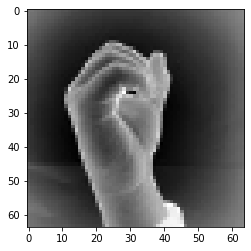

In [3]:
# show an image
import matplotlib.pyplot as plt
plt.imshow(X[0], cmap=plt.get_cmap('gray'))

In [4]:
y[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

### Reshape and split data

In [5]:
# reshape X
X = X.flatten().reshape(2062, 64*64)

In [6]:
X.shape

(2062, 4096)

In [7]:
y.shape

(2062, 10)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## Define model

In [15]:
model = Sequential()
model.add(Dense(200, input_dim=4096, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
# use callbacks so model won't run if it is not necessary
callbacks = [PlotLossesKeras(),
             EarlyStopping(monitor = 'val_loss', patience = 10),
             ReduceLROnPlateau(monitor = 'val_loss', patience = 5, factor = 1/2)]

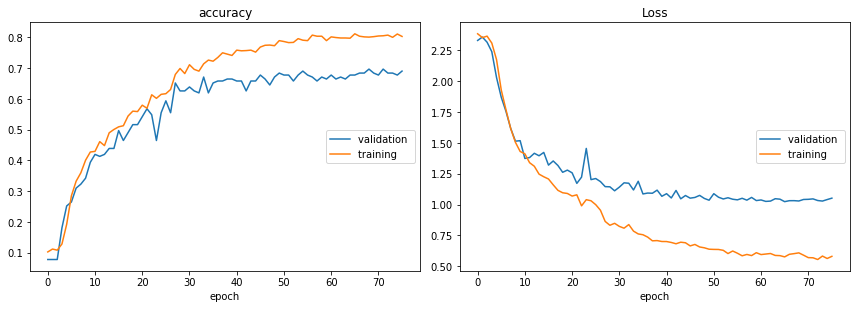

accuracy
	validation       	 (min:    0.077, max:    0.697, cur:    0.690)
	training         	 (min:    0.102, max:    0.812, cur:    0.803)
Loss
	validation       	 (min:    0.991, max:    2.358, cur:    1.052)
	training         	 (min:    0.555, max:    2.393, cur:    0.580)


In [17]:
model.fit(X_train, 
          y_train, 
          batch_size = 32, 
          epochs = 300, 
          validation_split = 0.1, 
          verbose = 1,
          callbacks = callbacks)

In [25]:
final_loss, final_accuracy = model.evaluate(X_test, y_test)


516/516 [==============================] - ETA:  - 0s 85us/step


In [26]:
print(f'The model final accuracy on test set is {final_accuracy:.2%}')

The model final accuracy on test set is 74.03%


In [30]:
# save model
model.save('silent_mnist.h5')

### Original plan
I actually wanted to tune parameters (like dropout rate and units in each dense layer) but I couldn't get this working in a reasonable amount of time. If you could provide me some hints/resource, I would really appreciate that. I didn't like the sklearn implementation since callbacks semmed to be really difficult to set

In [15]:
# would be nice to tune dropout rate too but training would take too much time
# early stoping might help that
def build_model(hp): # , dropout_rate
    
    model = Sequential()
    model.add(Dense(units=hp.Int('units',
                                        min_value=128,
                                        max_value=512,
                                        step=32), input_dim=4096, activation='sigmoid'))
    model.add(Dropout(rate=hp.Choice('rate',
                                             values=[0.1, 0.2, 0.3])))
    
    model.add(Dense(units=hp.Int('units',
                                        min_value=128,
                                        max_value=512, step=32), activation='sigmoid'))
    model.add(Dropout(rate=hp.Choice('rate',
                                             values=[0.1, 0.2, 0.3])))        
                    
    model.add(Dense(10, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
     
    return model

In [16]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='helloworld')

Traceback (most recent call last):
  File "C:\Users\gerol\Anaconda3\envs\ceu_dl\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-15-04bf06789de7>", line 6, in build_model
    model.add(Dense(units=hp.Int('units',
NameError: name 'Dense' is not defined


Traceback (most recent call last):
  File "C:\Users\gerol\Anaconda3\envs\ceu_dl\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-15-04bf06789de7>", line 6, in build_model
    model.add(Dense(units=hp.Int('units',
NameError: name 'Dense' is not defined


Traceback (most recent call last):
  File "C:\Users\gerol\Anaconda3\envs\ceu_dl\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-15-04bf06789de7>", line 6, in build_model
    model.add(Dense(units=hp.Int('units',
NameError: name 'Dense' is not defined


Traceback (most recent call last):
  File "C:\Users\gerol\Anaconda3\envs\ceu_dl\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-15-04bf06789de7>", line 6, in build_model
    model.add(Dense(units=hp.Int('units',
NameError: name 'Dense' is not defined


Traceback (most recent call last):
  File "C:\Users\gerol\Anaconda3\envs\ceu_dl\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-15-04bf06789de7>", line 6, in build_model
    model.add(Dense(units=hp.Int('units',
NameError: name 'Dense' is not defined


Traceback (most recent call last):
  File "C:\Users\gerol\Anaconda3\envs\ceu_dl\lib\site-packages\kerastuner\engine\hypermodel.py", line 105, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-15-04bf06789de7>", line 6, in build_model
    model.add(Dense(units=hp.Int('units',
NameError: name 'Dense' is not defined


RuntimeError: Too many failed attempts to build model.